In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from simulation import minimal_model as mm
from surrogate import neural_network

from sampling.grid import Grid
from sampling.random import Random
from sampling.lhs import LatinHyperCube, OrtogonalLatinHyperCube
from sampling.greedy_farpoint import GREEDYFP

from visualise import stream, surface

2024-06-06 16:17:43.559258: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 16:17:44.327021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Sampling example

In [3]:
def get_primes(n):
    out = list()
    sieve = [True] * (n+1)
    for p in range(2, n+1):
        if (sieve[p] and sieve[p]%2==1):
            out.append(p)
            for i in range(p, n+1, p):
                sieve[i] = False
    return out
primes = get_primes(20)
prime = primes[-1]
sq = int(np.sqrt(prime))

In [4]:
# All sampling methods instances you want to test.
sampling_methods = [Random, Grid, LatinHyperCube, OrtogonalLatinHyperCube, GREEDYFP]

In [5]:
n_samples = prime*prime
# Minimal model testing
g = 1.7
B_lim, D_lim = 2.9, 0.4
bounds = [(0, D_lim), (0, B_lim)]
n_samples

361

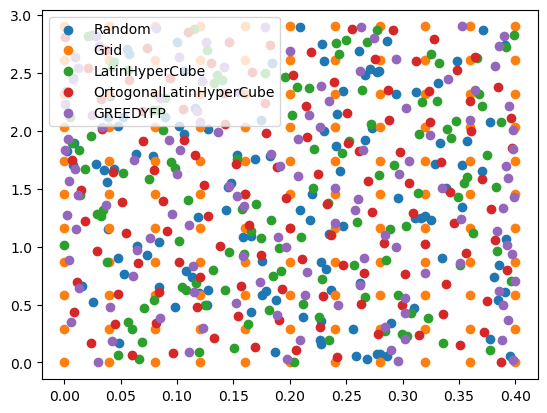

In [134]:
for method in sampling_methods:
    x, y = method.sample_stack(bounds, 121)
    plt.scatter(x,y, label=method.__name__)
plt.legend()
plt.show()

# EGO test
Efficient Global optimization.

In [8]:
# import numpy as np
# from scipy.optimize import minimize
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.preprocessing import StandardScaler
# from scipy.stats import norm  # Add this import

# class EGO:
#     def __init__(self, func, bounds, initial_points, noise=0.1):
#         self.func = func
#         self.bounds = bounds
#         self.noise = noise
#         self.X = np.array(initial_points)
#         self.y = np.array([self.func(x) for x in initial_points]).reshape(-1, 1)
#         self.scaler = StandardScaler().fit(self.X)
#         self.gpr = GaussianProcessRegressor(kernel=RBF(), alpha=noise**2)

#     def surrogate(self, X):
#         X_scaled = self.scaler.transform(X)
#         return self.gpr.predict(X_scaled, return_std=True)

#     def acquisition(self, X):
#         X = np.atleast_2d(X)  # Ensure X is 2D
#         mu, sigma = self.surrogate(X)
#         mu_opt = np.min(self.y)
#         z = (mu_opt - mu) / sigma
#         ei = (mu_opt - mu) * norm.cdf(z) + sigma * norm.pdf(z)
#         return -ei

#     def optimize_acquisition(self):
#         bounds = [(low, high) for low, high in self.bounds]
#         result = minimize(self.acquisition, np.random.uniform(*zip(*self.bounds)), bounds=bounds)
#         return result.x

#     def suggest_next_point(self, n_iter=1):
#         for _ in range(n_iter):
#             self.gpr.fit(self.scaler.transform(self.X), self.y)
#             next_point = self.optimize_acquisition()
#             self.X = np.vstack((self.X, next_point.reshape(1, -1)))
#             self.y = np.vstack((self.y, self.func(next_point).reshape(1, -1)))

#         return self.X[-1]

# # Example usage
# def test_function(x):
#     x = x[0]
#     return (x-2)*(x-5)*(x-8) + np.random.normal(0, 0.1)

# ego_optimizer = EGO(func=test_function, bounds=[(0, 10)], initial_points=[[5]])
# next_point = ego_optimizer.suggest_next_point()
# print("Next point to evaluate:", next_point)


In [9]:
# it = 20
# ego_optimizer = EGO(func=test_function, bounds=[(0, 10)], initial_points=[[5]])
# fig, ax = plt.subplots(it//2,2, figsize=(10,20))
# for i in range(it):
#     row_id = i//2
#     col_id = i%2
#     ax[row_id, col_id].plot(ego_optimizer.X,ego_optimizer.y, "o")
#     ego_optimizer.suggest_next_point()

In [10]:
# def minimal_test(x):
#     # print(x)
#     y = list(mm.step(x[0], x[1], 1.76))
#     # print(y)
#     return y[1]

# it = 10
# ego_optimizer = EGO(func=minimal_test, bounds=[(0, D_lim), (0, B_lim)], initial_points=[[0.2, 1.5], [0, 0], [D_lim, B_lim]])
# fig, ax = plt.subplots(it//2,2, figsize=(10,it*2))
# for i in range(it):
#     row_id = i//2
#     col_id = i%2
#     # print(ego_optimizer.X[:,0],ego_optimizer.X[:,1], ego_optimizer.y)
#     ax[row_id, col_id].plot(ego_optimizer.X[:,0],ego_optimizer.X[:,1], "o")
#     ego_optimizer.suggest_next_point()

# Data generation

## Custom LHS - Simulated annealing

In [11]:
# import copy
# import math
# import random

# def latin_hypercube_sampling(bounds, n_samples):
#     """
#     Generate Latin Hypercube Samples.

#     Parameters:
#         bounds (list of tuples): List of tuples where each tuple represents the lower and upper bounds of the variables.
#         n_samples (int): Number of samples to generate.

#     Returns:
#         np.array: Array of shape (n_samples, n_variables) containing the Latin Hypercube samples.
#     """
#     n_variables = len(bounds)
#     samples = np.zeros((n_samples, n_variables))

#     # Generate quantiles for each variable
#     quantiles = np.linspace(0, 1, n_samples + 1)

#     # Generate random permutation of indices for each variable
#     indices = [list(range(n_samples)) for _ in range(n_variables)]
#     for i in range(n_variables):
#         np.random.shuffle(indices[i])

#     # Assign values from quantiles to the samples
#     for i in range(n_variables):
#         for j in range(n_samples):
#             samples[j, i] = np.random.uniform(quantiles[indices[i][j]], quantiles[indices[i][j] + 1]) * (bounds[i][1] - bounds[i][0]) + bounds[i][0]

#     return samples

# def calculate_objective(samples):
#     """
#     Calculate the objective function.

#     Parameters:
#         samples (np.array): Array of shape (n_samples, n_variables) containing the samples.

#     Returns:
#         float: Value of the objective function.
#     """
#     # Example objective function: sum of squares of differences between samples
#     return np.sum(np.sum(np.diff(samples, axis=0) ** 2))

# def perturb_sample(sample, bounds, temperature):
#     """
#     Perturb a sample using simulated annealing.

#     Parameters:
#         sample (np.array): Array representing the sample to be perturbed.
#         bounds (np.array): Array of shape (n_variables, 2) representing the lower and upper bounds of the variables.
#         temperature (float): Current temperature in simulated annealing.

#     Returns:
#         np.array: Perturbed sample.
#     """
#     perturbed_sample = np.copy(sample)
#     for i in range(sample.shape[1]):  # Iterate over the number of variables (columns)
#         lower_bound, upper_bound = bounds[i]
#         for j in range(sample.shape[0]):  # Iterate over the number of samples (rows)
#             perturbed_sample[j, i] = np.minimum(upper_bound, np.maximum(lower_bound, sample[j, i] + np.random.uniform(-temperature, temperature)))
#     return perturbed_sample

# def simulated_annealing_lhs(bounds, n_samples, max_iterations, initial_temperature, cooling_rate):
#     """
#     Perform Latin Hypercube Sampling (LHS) with Simulated Annealing.

#     Parameters:
#         bounds (list of tuples): List of tuples where each tuple represents the lower and upper bounds of the variables.
#         n_samples (int): Number of samples to generate.
#         max_iterations (int): Maximum number of iterations for simulated annealing.
#         initial_temperature (float): Initial temperature for simulated annealing.
#         cooling_rate (float): Cooling rate for simulated annealing.

#     Returns:
#         np.array: Array of shape (n_samples, n_variables) containing the Latin Hypercube samples.
#     """
#     current_samples = latin_hypercube_sampling(bounds, n_samples)
#     current_objective = calculate_objective(current_samples)
#     best_samples = copy.deepcopy(current_samples)
#     best_objective = current_objective

#     temperature = initial_temperature
#     iteration = 0

#     while iteration < max_iterations and temperature > 0.001:
#         new_samples = perturb_sample(current_samples, bounds, temperature)
#         new_objective = calculate_objective(new_samples)
#         delta_objective = new_objective - current_objective
#         print(delta_objective, new_objective, current_objective,  math.exp(-delta_objective / temperature))

#         if delta_objective < 0 or random.random() < math.exp(-delta_objective / temperature):
#             current_samples = new_samples
#             current_objective = new_objective

#         if current_objective < best_objective:
#             best_samples = copy.deepcopy(current_samples)
#             best_objective = current_objective

#         temperature *= cooling_rate
#         # print(temperature)
#         iteration += 1
#     print(iteration, temperature)
#     return best_samples

# # Example usage:
# bounds = np.array([(0, 10), (-5, 5)])  # Example bounds for three variables
# # n_samples = 2**7  # Number of samples
# max_iterations = 1000  # Maximum number of iterations for simulated annealing
# initial_temperature = 100  # Initial temperature for simulated annealing
# cooling_rate = 0.99  # Cooling rate for simulated annealing

# samples = simulated_annealing_lhs(bounds, n_samples, max_iterations, initial_temperature, cooling_rate)
# # print(samples)
# # plt.plot(inital[:,0], inital[:,1], "o", color="blue")
# plt.plot(samples[:,0], samples[:,1], "o", color="green")
# plt.show()

In [12]:
# samples = sequential_adaptive_lhs(samples, bounds, variance, max_iterations, initial_temperature, cooling_rate)
# # print(samples)
# plt.plot(samples[:,0], samples[:,1], "o")
# plt.show()

In [13]:
# current_samples = latin_hypercube_sampling(bounds, 100)
# current_samples
# plt.plot(current_samples[:,0], current_samples[:,1], "o")
# plt.show()

# Running the minimal model

In [14]:
# Run miminal model
D_grid_fill, B_grid_fill = Grid.sample_stack([(0, D_lim), (0, B_lim)], n_samples)

dB_dt, dD_dt = mm.step(B_grid_fill, D_grid_fill, g, warm_up=0)

## Visualizing response

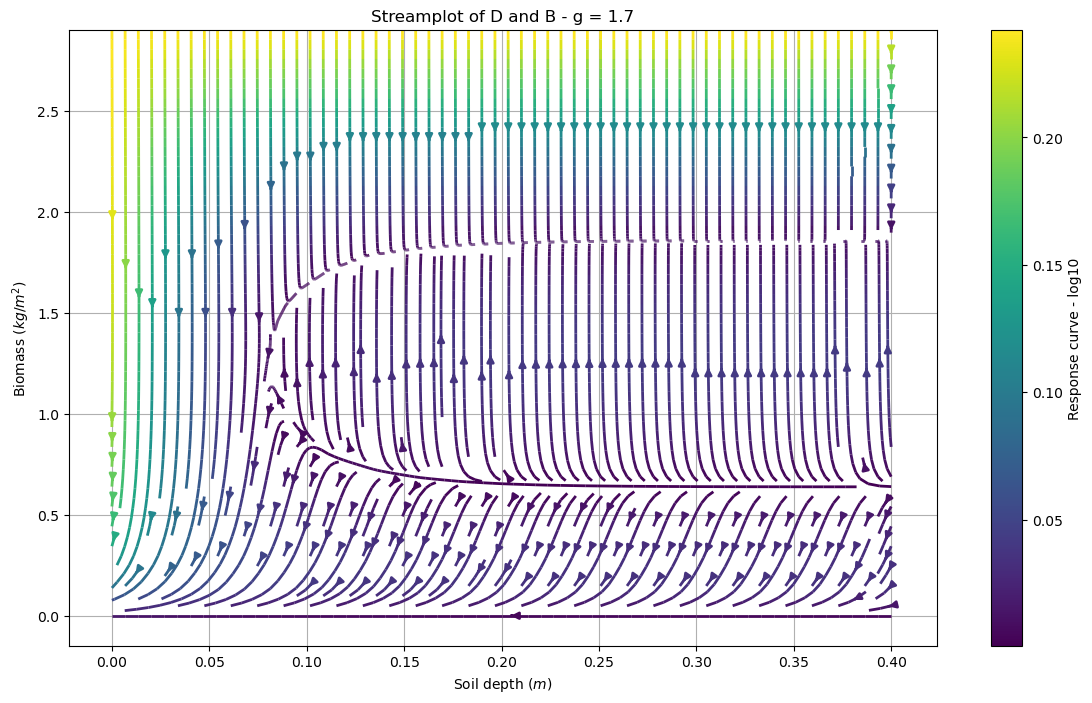

In [15]:
stream.show(D_grid_fill.reshape((prime, prime)), B_grid_fill.reshape((prime, prime)), dD_dt.reshape((prime, prime)), dB_dt.reshape((prime, prime)), g)

19


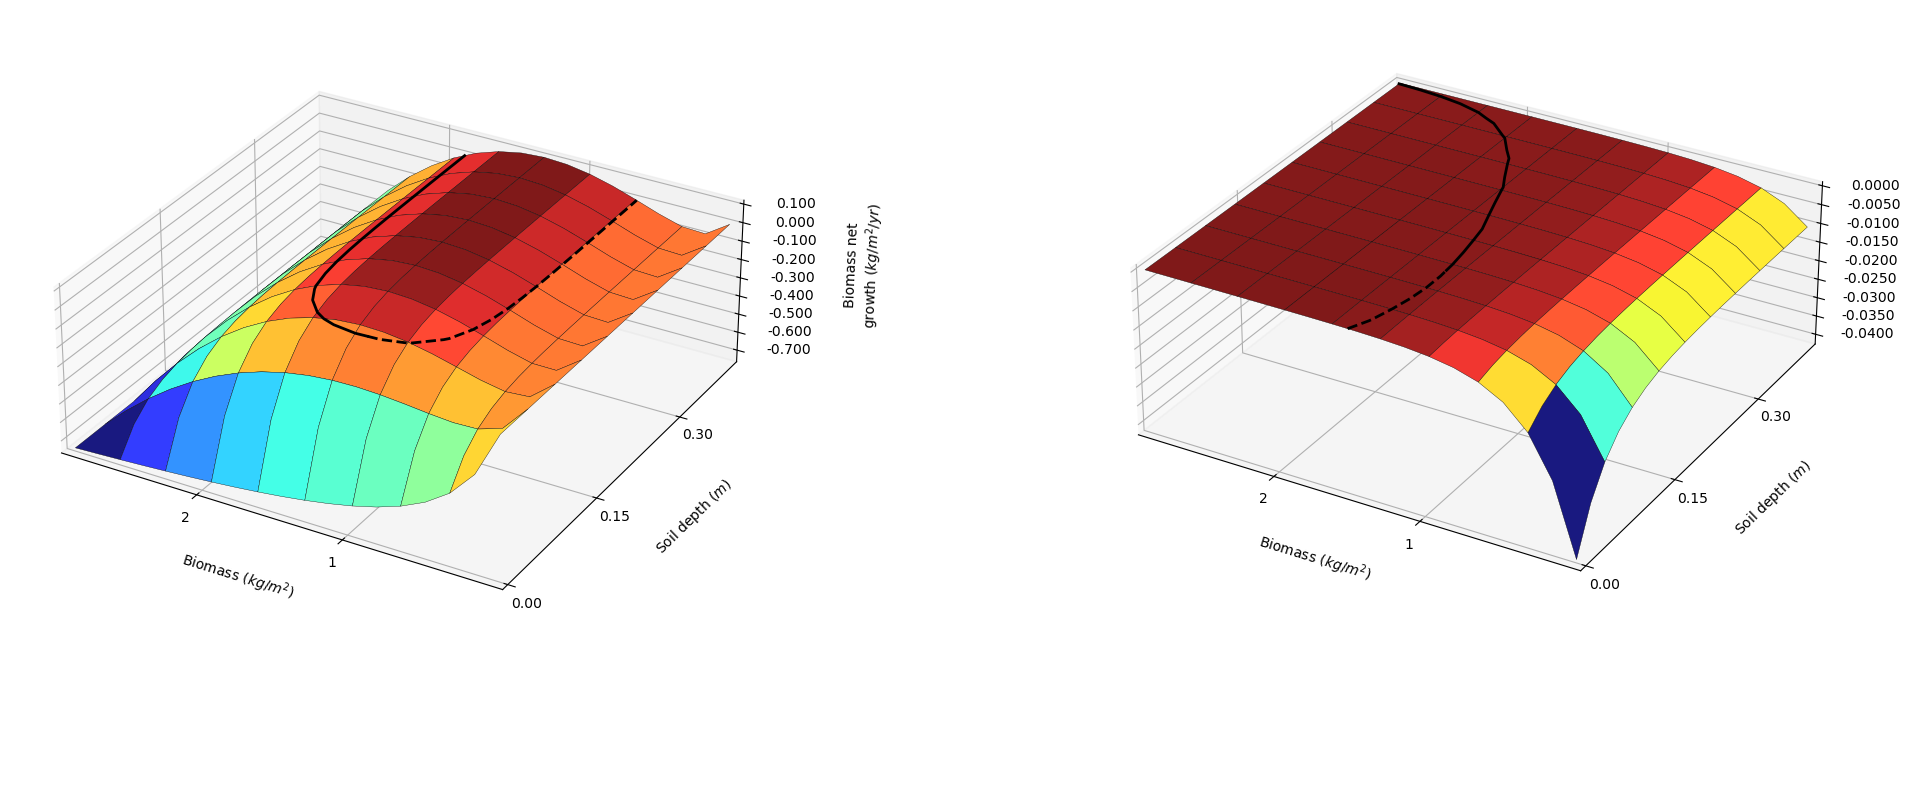

In [16]:
surface.show(D_grid_fill.reshape((prime, prime)), B_grid_fill.reshape((prime, prime)), dD_dt.reshape((prime, prime)), dB_dt.reshape((prime, prime)), D_lim, B_lim)

# Neural network

## Training

In [17]:
#  ['B', 'D', 'g', 'dB_dt', 'dD_dt']
X = np.column_stack([B_grid_fill.flatten(), D_grid_fill.flatten(), np.repeat(g, (n_samples))])
y = np.column_stack([dB_dt.flatten(), dD_dt.flatten()])
X.shape, y.shape

((361, 3), (361, 2))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

In [19]:
hp_1 = {
    'units': (9, 27, 81, 162, 324, 648, 1296),
    'act_fun': 'relu',
    'learning_rate': 1E-3,
    'batch_size': 2 ** 4,
    'l1_reg': 1e-5,
    'n_epochs': 200
}

hp_2 = {
    'units': (128, 512, 1024, 4096),
    'act_fun': 'relu',
    'learning_rate': 1E-3,
    'batch_size': 2 ** 5,
    'l1_reg': 1e-4,
    'n_epochs': 400
}

hp_3 = {
    'units': (128, 512, 1024, 4096),
    'act_fun': 'relu',
    'learning_rate': 1E-3,
    'batch_size': 2 ** 4,
    'l1_reg': 1e-4,
    'n_epochs': 400
}

hp_4 = {
    'units': [128, 512, 1024, 1024, 64, 16],
    'act_fun': 'relu',
    'learning_rate': 0.001,
    'batch_size': 16, 
    'l1_reg': 1e-06,
    'n_epochs': 400}

hp_5 = {
    'units': [256, 256, 256, 128, 64],
    'act_fun': 'relu',
    'learning_rate': 0.001,
    'batch_size': 32,
    'l2_reg': 1e-8,
    'n_epochs': 400}
hp = hp_5

In [20]:
# # NN = neural_network.NeuralNetwork(hp, uid="20240506_1840")
# NN = neural_network.NeuralNetwork(hp)
# NN.train(X_train, y_train, X_val, y_val)

# hist = neural_network.load_history(NN.uid)
# print(hist['hp']['units'])
# last_10 = hist['val_loss'][-10:]
# print(np.mean(last_10), np.median(last_10))
# neural_network.plot_history(hist)

In [21]:
# NN.save_model(NN.model, NN.name)

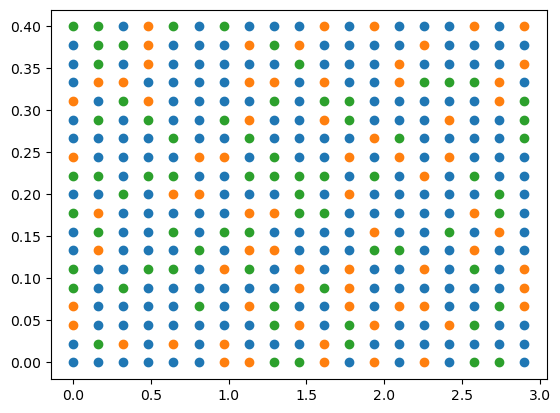

In [22]:
plt.plot(X_train[:,0], X_train[:,1], "o")
plt.plot(X_test[:,0], X_test[:,1], "o")
plt.plot(X_val[:,0], X_val[:,1], "o")
plt.show()

## Prediction

In [23]:
pred_grid = 196
sq = int(np.sqrt(pred_grid))
sq, sq*sq

(14, 196)

In [24]:
D_true, B_true = Grid.sample_stack([(0, D_lim), (0, B_lim)], pred_grid)
X_eval = np.column_stack((B_true.flatten(), D_true.flatten(), np.repeat(g, (sq*sq))))
dB_dt, dD_dt = mm.step(B_true, D_true, g, warm_up=0)

y_eval = np.column_stack((dB_dt.flatten(), dD_dt.flatten()))
X_eval.shape, y_eval.shape

((196, 3), (196, 2))

In [25]:
hp = neural_network.load_hp("20240606_120933")
NN = neural_network.NeuralNetwork(hp=hp, uid="20240606_120933")

2024-06-06 13:28:13.976982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 13:28:13.978234: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [26]:
y_pred = NN.model.predict(X_eval)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [27]:
mean_squared_error(y_eval, y_pred)

0.00016828645675304895

In [28]:
pred_dB_dt, pred_dD_dt = y_pred[:,0].reshape((sq,sq)), y_pred[:,1].reshape((sq,sq))
true_dB_dt, true_dD_dt = mm.step(B_true, D_true, g)

In [29]:
D_true.shape, B_true.shape, pred_dD_dt.shape, pred_dB_dt.shape

((196,), (196,), (14, 14), (14, 14))

In [30]:
# stream.show(D_true.reshape((sq, sq)), B_true.reshape((sq, sq)), pred_dD_dt, pred_dB_dt, g)

In [31]:
# surface.show(D_true.reshape((sq, sq)), B_true.reshape((sq, sq)), pred_dD_dt, pred_dB_dt, D_lim, B_lim)

In [32]:
# surface.show(D_true.reshape((sq, sq)), B_true.reshape((sq, sq)), true_dD_dt.reshape((sq,sq)), true_dB_dt.reshape((sq,sq)), D_lim, B_lim)

# Experiments

In [34]:
from simulation import minimal_model as mm
from surrogate import neural_network

from visualise import stream, surface

In [57]:
D_true, B_true = Grid.sample_stack([(0, D_lim), (0, B_lim)], pred_grid)
X_eval = np.column_stack((B_true.flatten(), D_true.flatten(), np.repeat(g, (sq*sq))))
dB_dt, dD_dt = mm.step(B_true, D_true, g, warm_up=0)
y_eval = np.column_stack((dB_dt.flatten(), dD_dt.flatten()))


def experiment(sampling_methods, n_requested_samples, ranges, hyper_parameters):
    random_state = 12345

    results = pd.DataFrame(columns=['method', 'n', 'mse_run', 'mse_method', 'mae_run', 'mae_method', 'hp', 'uid'])

    req_sqrt = [int(np.sqrt(n)) for n in n_requested_samples]
    primes = [get_primes(sq)[-1] for sq in req_sqrt]
    n_samples = [prime**2 for prime in primes]
    g = 1.76

    n_eval = 10**4
    D_true, B_true = Random.sample_stack(ranges, n_eval)
    true_dB_dt, true_dD_dt = mm.step(B_true, D_true, g, warm_up=0)
    # The same across all current experiments
    X_true = np.column_stack((B_true.flatten(), D_true.flatten(), np.repeat(g, (n_eval))))
    y_true = np.column_stack((true_dB_dt.flatten(), true_dD_dt.flatten()))
    X_true, X_val, y_true, y_val = train_test_split(X_true, y_true, test_size=0.5, shuffle=True, random_state=random_state)

    for method in sampling_methods:
        for i, n in enumerate(n_samples):
            method_name = str(method.__name__)
            # if applicable 10 refreshes per sample size
            refresh_max = int(n/10) if int(n/10) > 5 else 5

            D_points, B_points = method.sample_stack(ranges, n, random_state=random_state, refresh_count=refresh_max, scale=2)
            train_dB_dt, train_dD_dt = mm.step(B_points, D_points, g)
            X = np.column_stack([B_points.flatten(), D_points.flatten(), np.repeat(g, (n))])
            y = np.column_stack([train_dB_dt.flatten(), train_dD_dt.flatten()])
            print(method_name, n, X.shape)

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=random_state)

            NN = neural_network.NeuralNetwork(hyper_parameters)
            NN.train(X_train, y_train, X_val, y_val, verbose=False)

            y_true_pred = NN.predict(X_true)
            y_test_pred = NN.predict(X_test)

            new_row = pd.DataFrame([{
                'method': method_name,
                'n': n,
                'mse_run': mean_squared_error(y_true, y_true_pred),
                'mse_method': mean_squared_error(y_test, y_test_pred),
                'mae_run': mean_absolute_error(y_true, y_true_pred),
                'mae_method': mean_absolute_error(y_test, y_test_pred),
                'hp': hyper_parameters,
                'uid': NN.uid,
                'epochs': len(NN.history.history['loss'])
            }])
            results = pd.concat([results, new_row], ignore_index=True)

    return results

In [58]:
# All sampling methods instances you want to test.
sampling_methods = [Random, Grid, LatinHyperCube, OrtogonalLatinHyperCube, GREEDYFP]

# Approximations of N total samples. Should be cubes of a prime. Will be translated if it is not.
n_requested_samples = [25, 50, 121, 200, 530, 2025]

In [59]:
results = experiment(sampling_methods, n_requested_samples, bounds, hp_5)

Random 25 (25, 3)
NN training time: 0.834 minutes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Random 49 (49, 3)


/tmp/ipykernel_1056333/2902221172.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


NN training time: 0.539 minutes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Random 121 (121, 3)
NN training time: 1.08 minutes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Random 169 (169, 3)
NN training time: 1.08 minutes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Random 529 (529, 3)
NN training time: 1.19 minutes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
Random 1849 (1849, 3)
NN training time: 0.9 minutes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
Grid 25 (25, 3)
NN training time: 0.345 minutes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Grid 49 (49, 3)
NN training time: 0.888 minutes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Grid 121 (121, 3)
NN training time: 1.08 minutes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━

In [60]:
# uids = results[results['method'] == 'Random\'>']['uid'].values
# for uid in uids:
#     hist = neural_network.load_history(uid)
#     neural_network.plot_history(hist)

In [61]:
df = results.copy(deep=True)
df['mae_diff'] = np.abs(df['mae_method'] - df['mae_run'])
df['mse_diff'] = np.abs(df['mse_method'] - df['mse_run'])
df

,method,n,mse_run,mse_method,mae_run,mae_method,hp,uid,epochs,mae_diff,mse_diff
0,Random,25,2.445592e-02,0.021285,0.081404,0.086562,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240606_190626,313.0,0.005159,3.170635e-03
1,Random,49,2.005375e-02,0.034566,0.080852,0.121566,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240606_190717,198.0,0.040714,1.451215e-02
2,Random,121,2.822953e-03,0.001189,0.013158,0.008301,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240606_190749,400.0,0.004857,1.634105e-03
3,Random,169,4.716300e-03,0.006328,0.019799,0.022728,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240606_190855,400.0,0.002929,1.611689e-03
4,Random,529,1.213333e-05,0.000025,0.001126,0.001319,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240606_191000,400.0,0.000193,1.261863e-05
5,Random,1849,1.743292e-05,0.000019,0.002064,0.002094,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240606_191112,215.0,0.000030,1.823398e-06
6,Grid,25,1.587871e-02,0.020417,0.074121,0.075702,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240606_191206,121.0,0.001581,4.538468e-03
7,Grid,49,6.596755e-03,0.024781,0.030116,0.053073,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240606_191227,333.0,0.022957,1.818471e-02
8,Grid,121,4.011737e-03,0.013041,0.018082,0.032296,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240606_191321,400.0,0.014214,9.029121e-03
9,Grid,169,4.598111e-04,0.002050,0.006024,0.012586,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240606_191426,400.0,0.006562,1.589736e-03


In [ ]:
# uids = results[results['method'] == 'OrtogonalLatinHyperCube\'>']['uid'].values
# for uid in uids:
#     hist = neural_network.load_history(uid)
#     neural_network.plot_history(hist)

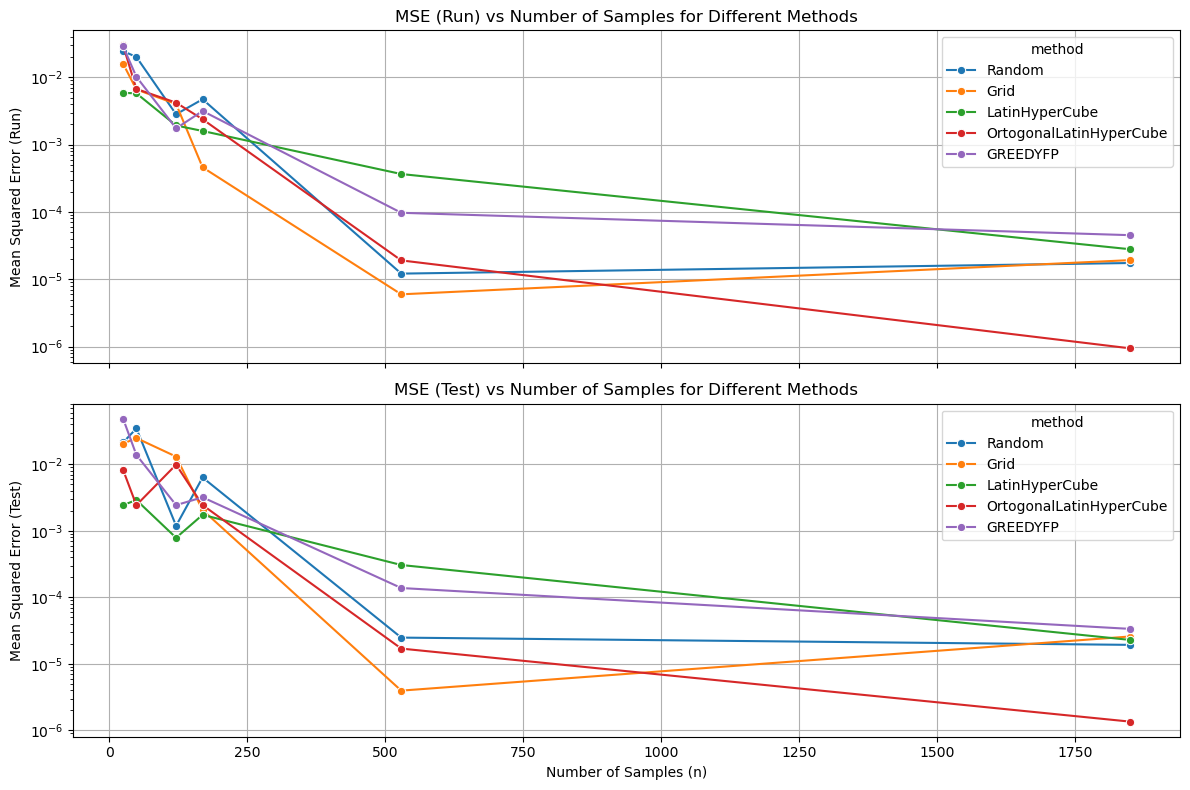

In [62]:
def plot_results_seaborn(results):
    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

    # Plot the first lineplot on the first axis
    sns.lineplot(data=results, x='n', y='mse_run', hue='method', marker='o', ax=ax1)
    ax1.set_ylabel('Mean Squared Error (Run)')
    ax1.set_title('MSE (Run) vs Number of Samples for Different Methods')
    ax1.set_yscale('log')
    ax1.grid(True)

    # Plot the second lineplot on the second axis
    sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax2)
    ax2.set_xlabel('Number of Samples (n)')
    ax2.set_ylabel('Mean Squared Error (Test)')
    ax2.set_title('MSE (Test) vs Number of Samples for Different Methods')
    ax2.set_yscale('log')
    ax2.grid(True)

    plt.tight_layout()

    # Show the plot
    plt.show()

plot_results_seaborn(results)

In [63]:
df.to_csv(f"data/experiments/{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv")